In [59]:
# imports and plotting utility functions
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pylab as plt
#from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from scipy.linalg import norm

rf_cmp = RandomForestClassifier(n_estimators=250, bootstrap=True, oob_score=True, random_state=0)

def plot_lr(true_coefs, est_coefs, pvals, var_names=None, rf_cmp_coef=None):
    n_feat = len(est_coefs)
    where_sign = lr_pvalues < 0.05
    plt.figure(figsize=(17, 6))
    # print non-significant betas
    plt.scatter(np.arange(X.shape[1]), est_coefs, s=150, color='red', label='estimated betas', alpha=0.5)
    if true_coefs is not None:
        plt.scatter(np.arange(X.shape[1]), true_coefs, s=150, color='black', label='true betas', alpha=0.5)
    if rf_cmp_coef is not None:
        plt.scatter(np.arange(X.shape[1]), rf_cmp_coef, s=150, marker='D', color='steelblue', label='RandomForest importances', alpha=0.5)

    # print star significant betas and their values
    axes = plt.gca()
    #import pdb; pdb.set_trace()
    y_min, y_max = axes.get_ylim()
    axes.set_ylim(y_min * 1.25, y_max * 1.25)
    sign_y = np.sum(where_sign) * [y_min]
    plt.scatter(np.arange(X.shape[1])[where_sign], sign_y, color='red', label='significant at p<0.05', s=150, marker=(5, 1), alpha=0.75, linewidth=3)
    for i_b, p in enumerate(pvals):
        plt.text(x=i_b - 0.25, y=y_min * 1.10, s='$p$=%.3f' % p)

    plt.xlabel('input variables')
    if var_names is None:
        plt.xticks(np.arange(n_feat), (np.arange(n_feat) + 1), fontsize=15)
    else:
        plt.xticks(np.arange(n_feat), var_names, fontsize=12, rotation=90)
    plt.grid(True)
    plt.title('Logistic regression', fontsize=16)
    plt.legend(loc='upper right', fontsize=14, fancybox=True, framealpha=0.5)

def plot_regr_paths(coefs, accs, nonzeros, C_grid, var_names=None, unbiased_accs=None):
    n_cols = 2
    n_rows = 1
    n_verticals = len(coefs)
    n_feat = len(coefs)

    my_palette = np.array([
        '#F47D7D', '#FBEF69', '#98E466', '#000000',
        '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030', 'grey', 'blue', 'salmon', '#4BBCF6',
        'green', 'tomato', 'darkred', 'black', 'cyan', 'lime'
    ])
    my_colors = np.array(['???????'] * coefs.shape[-1])
    i_col = 0
    new_grp_pts_x = []
    new_grp_pts_y = []
    new_grp_pts_col = []
    new_grp_pts_total = []

    for i_vertical, (params, acc, C) in enumerate(zip(
        coefs, accs, C_grid)):
        b_notset = my_colors == '???????'
        b_nonzeros = params == 0
        b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)

        #if i_vertical >= 17:
        #    import pdb; pdb.set_trace()

        if np.sum(b_coefs_of_new_grp) > 0:
            i_col += 1

            # we found a new subset that became 0
            for new_i in np.where(b_coefs_of_new_grp == True)[0]:
                # color all coefficients of the current group
                cur_col = my_palette[i_col]
                my_colors[new_i] = cur_col

            new_grp_pts_x.append(C)
            new_grp_pts_y.append(acc)
            new_grp_pts_col.append(cur_col)
            new_grp_pts_total.append(np.sum(b_nonzeros))

    if var_names is None:
        X_colnames = np.arange(n_feat) + 1
    else:
        X_colnames = var_names
            
    subplot_xlabel = '#nonzero coefficients'

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(15, 10), facecolor='white')
    t, i_col = 0, 0

    for i_line in range(X.shape[-1]):
        axarr[i_col].plot(np.log10(C_grid)[::-1],
            coefs[:, i_line], label=X_colnames[i_line],
                color=my_colors[i_line], linewidth=1.5)

    # axarr[0].set_xticks(np.arange(len(C_grid)))
    # axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
    axarr[i_col].set_xlabel(subplot_xlabel, fontsize=10)
    axarr[i_col].legend(loc='lower left', fontsize=11, markerscale=10, fancybox=True, framealpha=0.5)
    axarr[0].grid(True)
    # axarr[i_col].set_ylabel('Item groups', fontsize=16)
    axarr[0].set_title('Penalized Logistic: Groups of selected variables', fontsize=16)
    axarr[0].set_xticks(np.log10(C_grid)[::-1])
    axarr[0].set_xticklabels(nonzeros)

    # axarr[1].axis('off')
    #import pdb; pdb.set_trace()
    if unbiased_accs is not None:
        axarr[1].plot(np.arange(len(unbiased_accs)), unbiased_accs, color='orange',
                     linewidth=4, label='prediction accuracy (debiased)')
    axarr[1].plot(np.arange(len(accs)), accs, color='black',
                     linewidth=3, label='prediction accuracy')
    # axarr[1].set_title('ACCURACY')
    axarr[1].set_ylim(0, 1.05)
    axarr[1].grid(True)
    # axarr[1].set_xticklabels(np.log10(C_grid), '')
    axarr[1].set_xticks(np.arange(n_verticals))
    axarr[1].set_xticklabels(nonzeros)
    axarr[1].set_xlabel(subplot_xlabel, fontsize=10)
    # axarr[1].set_ylabel('Out-of-sample accuracy', fontsize=16)
    axarr[1].legend(loc='lower left', fontsize=14, markerscale=10, fancybox=True, framealpha=0.5)
    axarr[1].set_title('Penalized Logistic: Out-of-sample accuracy ($R^2$ score)', fontsize=16)

    
def corrfunc(x, y, **kws):
    from scipy import stats
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


In [68]:
import statsmodels.api as sm

# https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm
def fwd_stepwise_selection(X, y, initial_list=[], verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while len(included) < X.shape[1]:
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        best_feature = new_pval.argmin()
        included.append(best_feature)
        if verbose:
            print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
    return included

In [61]:
# statistical helper functions
def compute_Logistic_regpath(X, y, C_grid):
    coef_list2 = []
    acc_list2 = []
    acc_unbiased_list2 = []
    nonzero_list2 = []
    for i_step, my_C in enumerate(C_grid):
        sample_accs = []
        sample_accs_unbiased = []
        sample_coef = []
        for i_subsample in range(100):
            folder = ShuffleSplit(n=len(y), n_iter=100, test_size=0.1,
                                            random_state=i_subsample)
            train_inds, test_inds = iter(folder).next()

            clf = LogisticRegression(C=my_C, random_state=i_subsample, penalty='l1')

            clf.fit(X[train_inds, :], y[train_inds])
            acc = np.mean(y[test_inds] == clf.predict(X[test_inds]))
            
            # get out-of-sample accuracy from unbiased linear model with selected inputs
            b_vars_to_keep = np.squeeze(clf.coef_) != 0
            if np.sum(b_vars_to_keep) > 0:
                unbiased_lr = LogisticRegression(C=100000, random_state=i_subsample, penalty='l2')
                unbiased_lr.fit(
                  X[train_inds, :][:, b_vars_to_keep], y[train_inds])
                unbiased_acc = np.mean(
                        y[test_inds] == unbiased_lr.predict(X[test_inds][:, b_vars_to_keep]))
            else:
                unbiased_acc = 0

            sample_accs.append(acc)
            sample_accs_unbiased.append(unbiased_acc)
            sample_coef.append(np.squeeze(clf.coef_))

        mean_coefs = np.mean(np.array(sample_coef), axis=0)
        coef_list2.append(mean_coefs)
        acc_list2.append(np.mean(sample_accs))
        acc_unbiased_list2.append(np.mean(sample_accs_unbiased))
        notzero = np.count_nonzero(mean_coefs)
        print "C: %.4f acc: %.2f active_coefs: %i" % (my_C, acc, notzero)
        nonzero_list2.append(notzero)
    return np.array(coef_list2), np.array(acc_list2), np.array(nonzero_list2), np.array(acc_unbiased_list2)

# Heart dataset (ISL)

Dataset summary: These data contain a binary outcome HD for 303 patients who presented with chest pain (binary outcome). 

In [62]:
import pandas as pd
df_heart = pd.read_csv('dataset_heart_ISL.csv').fillna(value=0)
feat_names = ['Age', u'Sex', u'RestBP', u'Chol', u'Fbs',
       u'RestECG', u'MaxHR', u'ExAng', u'Oldpeak', u'Slope', u'Ca', u'Thal', u'ChestPain']
y = np.asarray(df_heart['AHD'] == 'Yes', dtype=np.int)

df_part1 = pd.DataFrame(StandardScaler().fit_transform(df_heart[feat_names[:-2]].values), columns=feat_names[:-2])
df_part2 = pd.get_dummies(df_heart[feat_names[-2:]])
#pd.concat([df_part1, df_part2], axis=1)
X = np.hstack((df_part1.values, df_part2.values))
feat_names = list(df_part1.columns) + list(df_part2.columns)



In [55]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
             kind="reg", diag_kind="kde", hue='out')
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/admin/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/admin/anaconda2/lib/python2.7/site-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


C: 10.0000 acc: 0.81 active_coefs: 19
C: 7.4989 acc: 0.81 active_coefs: 19
C: 5.6234 acc: 0.81 active_coefs: 19
C: 4.2170 acc: 0.81 active_coefs: 19
C: 3.1623 acc: 0.81 active_coefs: 19
C: 2.3714 acc: 0.81 active_coefs: 19
C: 1.7783 acc: 0.81 active_coefs: 17
C: 1.3335 acc: 0.81 active_coefs: 17
C: 1.0000 acc: 0.77 active_coefs: 17
C: 0.7499 acc: 0.77 active_coefs: 17
C: 0.5623 acc: 0.77 active_coefs: 17
C: 0.4217 acc: 0.77 active_coefs: 17
C: 0.3162 acc: 0.77 active_coefs: 15
C: 0.2371 acc: 0.77 active_coefs: 14
C: 0.1778 acc: 0.77 active_coefs: 14
C: 0.1334 acc: 0.74 active_coefs: 14
C: 0.1000 acc: 0.74 active_coefs: 13
C: 0.0750 acc: 0.74 active_coefs: 11
C: 0.0562 acc: 0.74 active_coefs: 9
C: 0.0422 acc: 0.74 active_coefs: 7
C: 0.0316 acc: 0.74 active_coefs: 7
C: 0.0237 acc: 0.71 active_coefs: 4
C: 0.0178 acc: 0.77 active_coefs: 4
C: 0.0133 acc: 0.52 active_coefs: 0
C: 0.0100 acc: 0.52 active_coefs: 0


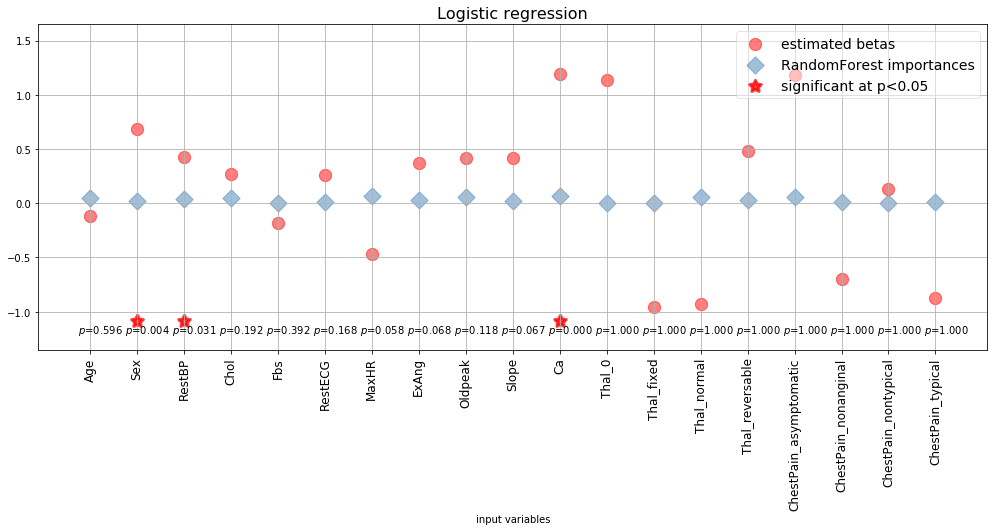

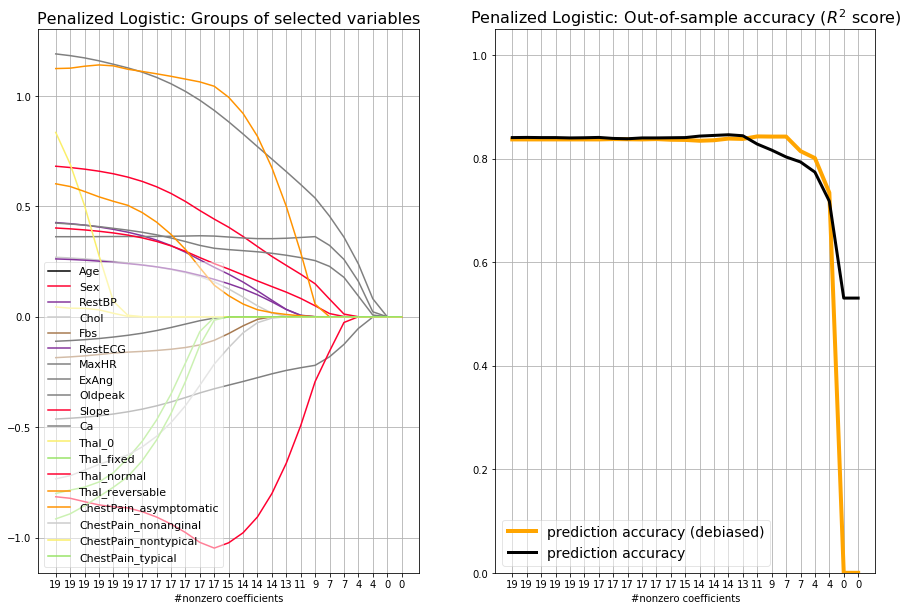

In [63]:
# ordinary least squares
model = Logit(y, X)
res = model.fit(disp=0)
lr_coefs = res.params
lr_pvalues = res.pvalues

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(+1, -2, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Logistic_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

In [64]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  Thal_normal                    with p-value 1.01554e-17
Add  ChestPain_asymptomatic         with p-value 8.76513e-12
Add  Ca                             with p-value 5.44918e-08
Add  Oldpeak                        with p-value 0.000292995
Add  ExAng                          with p-value 0.0177969
Add  RestECG                        with p-value 0.0487469
Add  Sex                            with p-value 0.0720185
Add  MaxHR                          with p-value 0.0784324
Add  RestBP                         with p-value 0.0625983
Add  Thal_fixed                     with p-value 0.062896
Add  Slope                          with p-value 0.116818
Add  ChestPain_nontypical           with p-value 0.0956932
Add  Chol                           with p-value 0.225965
Add  Fbs                            with p-value 0.414937
Add  Age                            with p-value 0.585244
Add  Thal_0                         with p-value 0.735713
Add  ChestPain_nonanginal           with p-value 0.782

In [72]:
res.summary(xname=feat_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  303
Model:                          Logit   Df Residuals:                      285
Method:                           MLE   Df Model:                           17
Date:                Wed, 14 Mar 2018   Pseudo R-squ.:                  0.5285
Time:                        15:33:49   Log-Likelihood:                -98.548
converged:                       True   LL-Null:                       -208.99
                                        LLR p-value:                 1.745e-37
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Age                       -0.1180      0.223     -0.530      0.596      -0.554       0.318
Sex                        0.6847      0.239      2.859      0.004       0.215       1.154
RestBP                     0.4237      0.196      2.161      0.031       0.039       0.808
Chol                       0.2679      0.205      1.305      0.192      -0.134       0.670
Fbs                       -0.1784      0.208     -0.856      0.392      -0.587       0.230
RestECG                    0.2583      0.187      1.379      0.168      -0.109       0.625
MaxHR                     -0.4647      0.245     -1.895      0.058      -0.946       0.016
ExAng                      0.3708      0.203      1.823      0.068      -0.028       0.769
Oldpeak                    0.4189      0.268      1.564      0.118      -0.106       0.944
Slope                      0.4164      0.228      1.830      0.067      -0.030       0.862
Ca                         1.1919      0.254      4.692      0.000       0.694       1.690
Thal_0                     1.1389   1.06e+07   1.08e-07      1.000   -2.07e+07    2.07e+07
Thal_fixed                -0.9576   1.06e+07  -9.05e-08      1.000   -2.07e+07    2.07e+07
Thal_normal               -0.9272   1.06e+07  -8.76e-08      1.000   -2.07e+07    2.07e+07
Thal_reversable            0.4805   1.06e+07   4.54e-08      1.000   -2.07e+07    2.07e+07
ChestPain_asymptomatic     1.1782   1.06e+07   1.11e-07      1.000   -2.07e+07    2.07e+07
ChestPain_nonanginal      -0.6998   1.06e+07  -6.62e-08      1.000   -2.07e+07    2.07e+07
ChestPain_nontypical       0.1346   1.06e+07   1.27e-08      1.000   -2.07e+07    2.07e+07
ChestPain_typical         -0.8784   1.06e+07   -8.3e-08      1.000   -2.07e+07    2.07e+07
==========================================================================================
"""

### conclusion: only 1 of 3 significant variables is among the 4 most predictive ones

# South African Heart dataset: more significant than predictable

Dataset summary (ESL): A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa. There are roughly two controls per case of coronary heart disease. Many of the coronary heart disease positive men have undergone blood pressure reduction treatment and other programs to reduce their risk
factors after their coronary heart disease event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in Rousseauw et al, 1983, South African Medical Journal.

Based on this data, does having a family history of coronary heart disease affect a patients chance of having coronary heart disease? Does this result change for patients younger than 40 years old? What about for patients aged 40 years or older?

sbp		systolic blood pressure
tobacco		cumulative tobacco (kg)
ldl		low densiity lipoprotein cholesterol
adiposity
famhist		family history of heart disease (Present, Absent)
typea		type-A behavior
obesity
alcohol		current alcohol consumption
age		age at onset
chd		response, coronary heart disease

In [15]:
import pandas as pd
df_africa = pd.read_excel('dataset_south_african_heart_disease.xls')

df_africa

,row,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
5,6,132,6.20,6.47,36.21,Present,62,30.77,14.14,45,0
6,7,142,4.05,3.38,16.20,Absent,59,20.81,2.62,38,0
7,8,114,4.08,4.59,14.60,Present,62,23.11,6.72,58,1
8,9,114,0.00,3.83,19.40,Present,49,24.86,2.49,29,0
9,10,132,0.00,5.80,30.96,Present,69,30.11,0.00,53,1


In [16]:
feat_names = ['sbp', u'tobacco', u'ldl', u'adiposity', u'famhist', u'typea',
       u'obesity', u'alcohol', u'age']
df_africa['famhist'] = df_africa['famhist'] == 'Present'
X = StandardScaler().fit_transform(df_africa[feat_names].values)
y = df_africa['chd'].values

/Users/admin/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


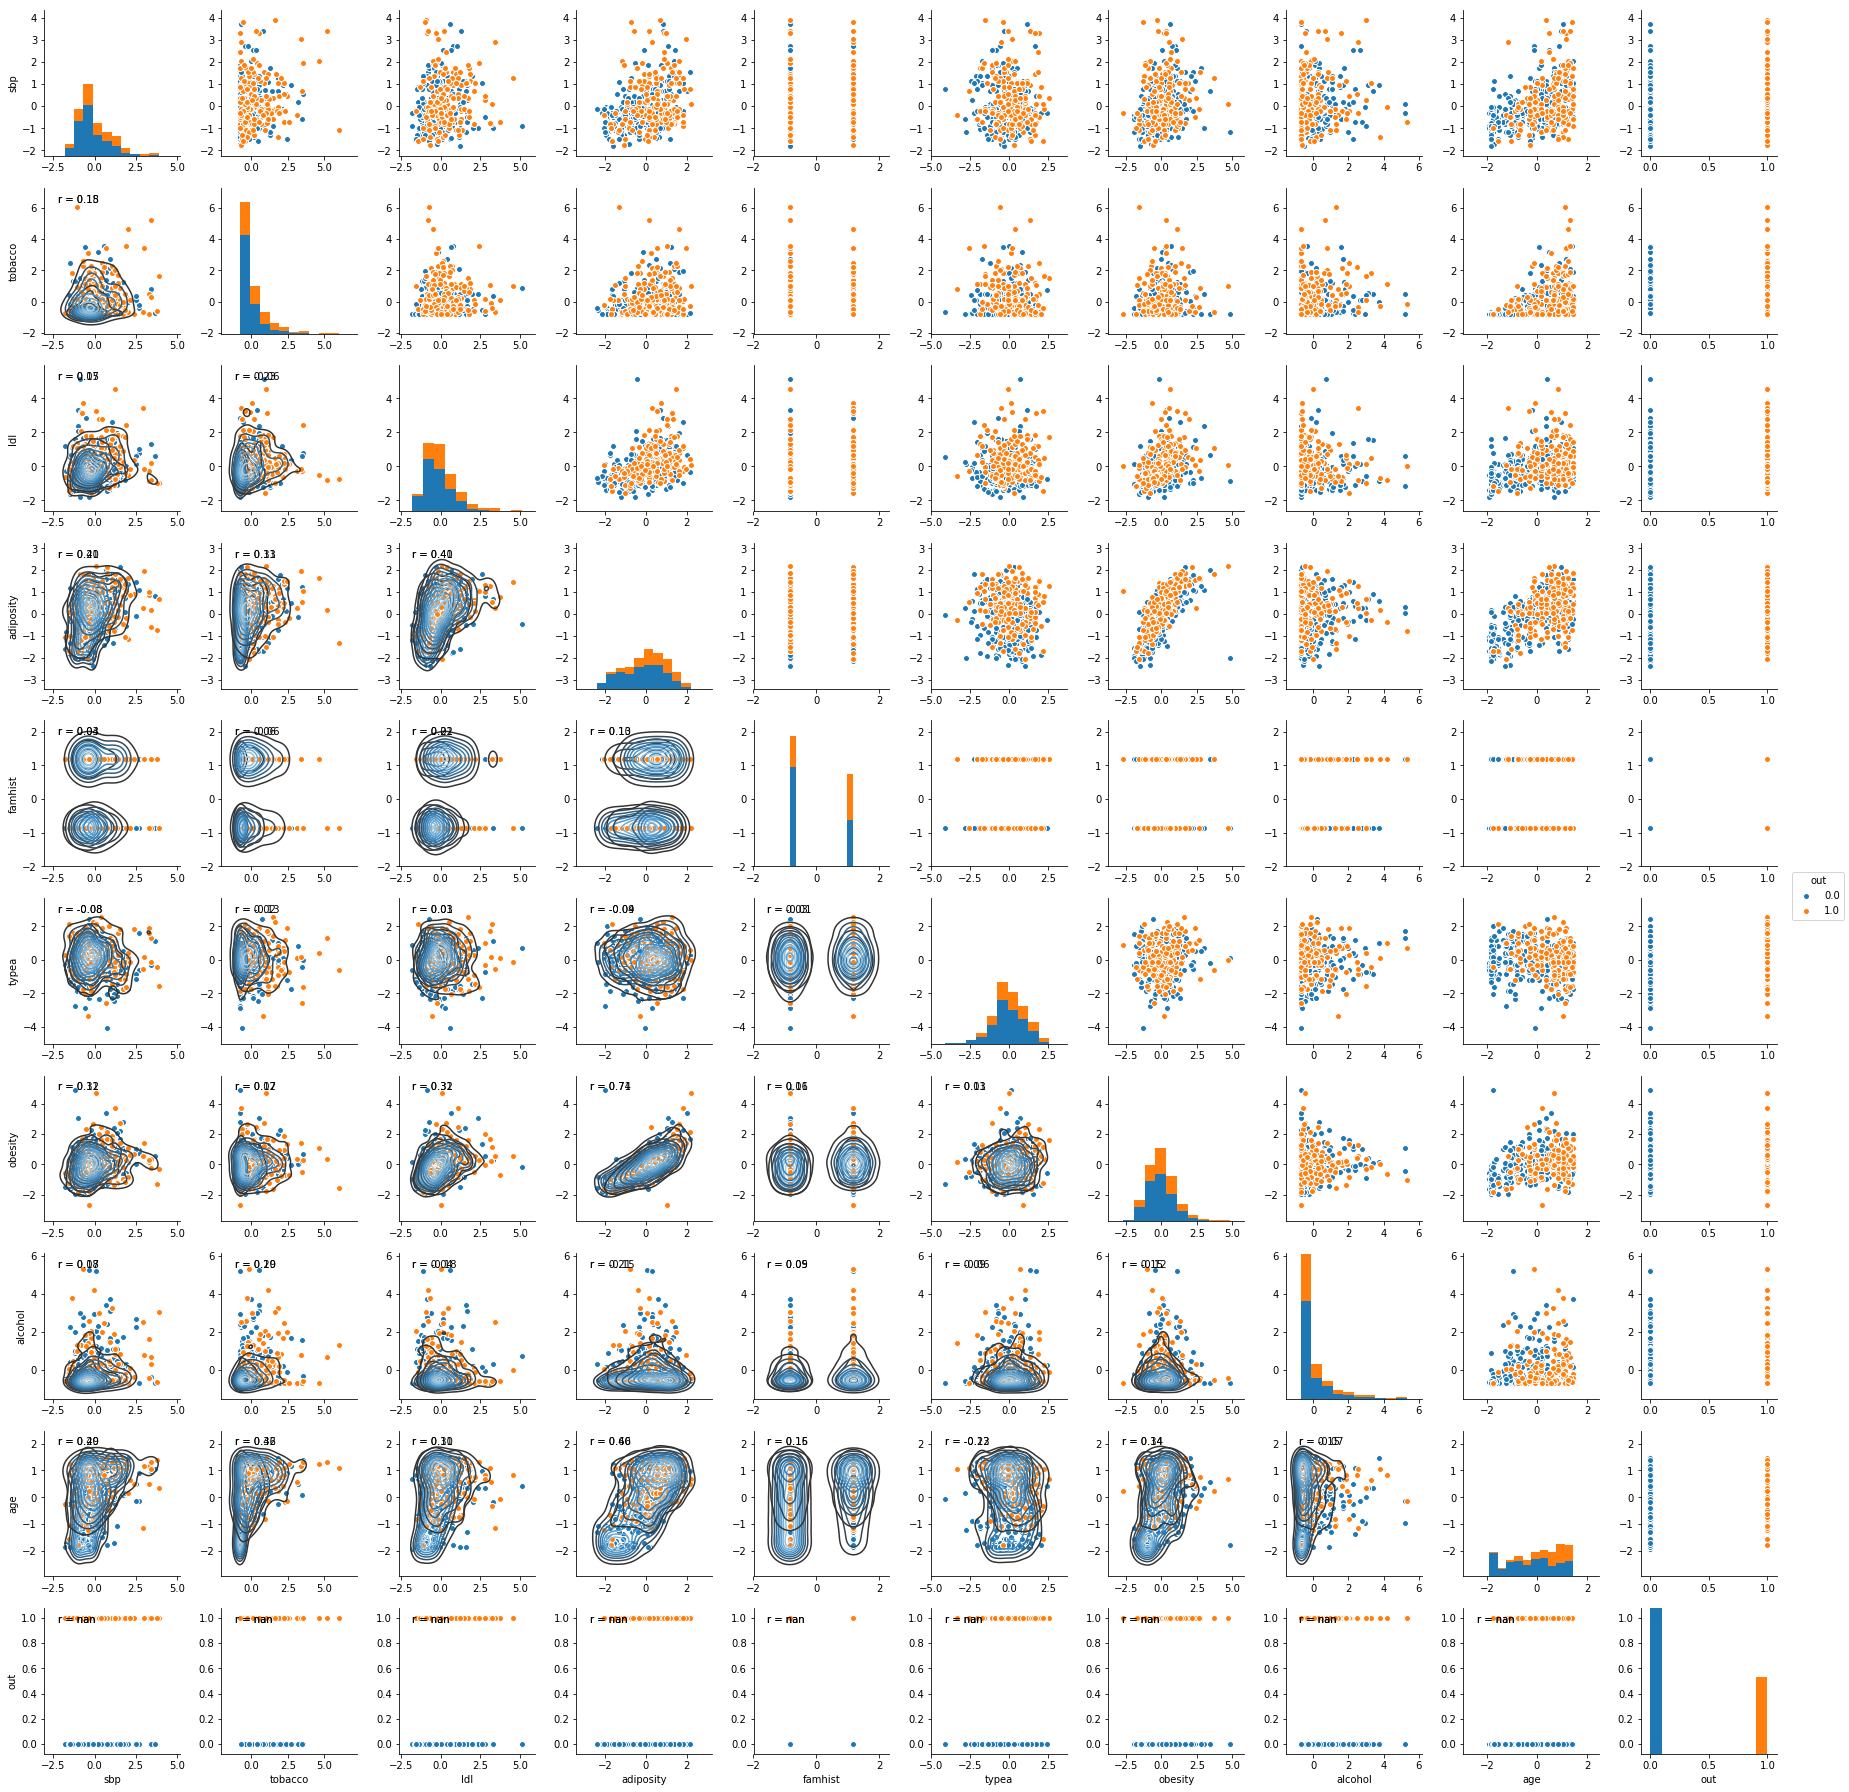

In [42]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
              hue='out')
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

Signal-to-noise ratio: 0.0003
alpha: 0.0001 acc: 0.34 active_coefs: 9
alpha: 0.0002 acc: 0.34 active_coefs: 9
alpha: 0.0002 acc: 0.34 active_coefs: 9
alpha: 0.0003 acc: 0.34 active_coefs: 9
alpha: 0.0005 acc: 0.34 active_coefs: 9
alpha: 0.0008 acc: 0.34 active_coefs: 9
alpha: 0.0012 acc: 0.35 active_coefs: 9
alpha: 0.0017 acc: 0.35 active_coefs: 9
alpha: 0.0026 acc: 0.35 active_coefs: 9
alpha: 0.0039 acc: 0.35 active_coefs: 9
alpha: 0.0059 acc: 0.36 active_coefs: 9
alpha: 0.0089 acc: 0.36 active_coefs: 9
alpha: 0.0133 acc: 0.36 active_coefs: 8
alpha: 0.0200 acc: 0.35 active_coefs: 8
alpha: 0.0301 acc: 0.33 active_coefs: 7
alpha: 0.0453 acc: 0.30 active_coefs: 6
alpha: 0.0681 acc: 0.24 active_coefs: 5
alpha: 0.1024 acc: 0.12 active_coefs: 4
alpha: 0.1540 acc: 0.01 active_coefs: 1
alpha: 0.2315 acc: -0.02 active_coefs: 0
alpha: 0.3481 acc: -0.02 active_coefs: 0
alpha: 0.5233 acc: -0.02 active_coefs: 0
alpha: 0.7867 acc: -0.02 active_coefs: 0
alpha: 1.1828 acc: -0.02 active_coefs: 0
alpha

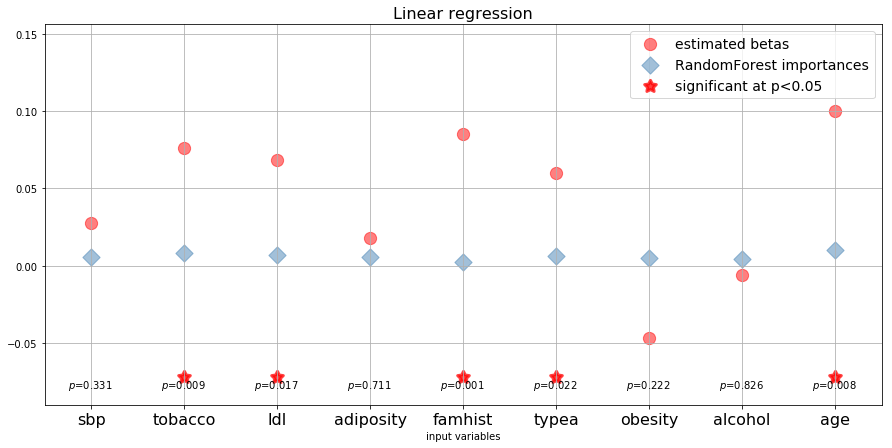

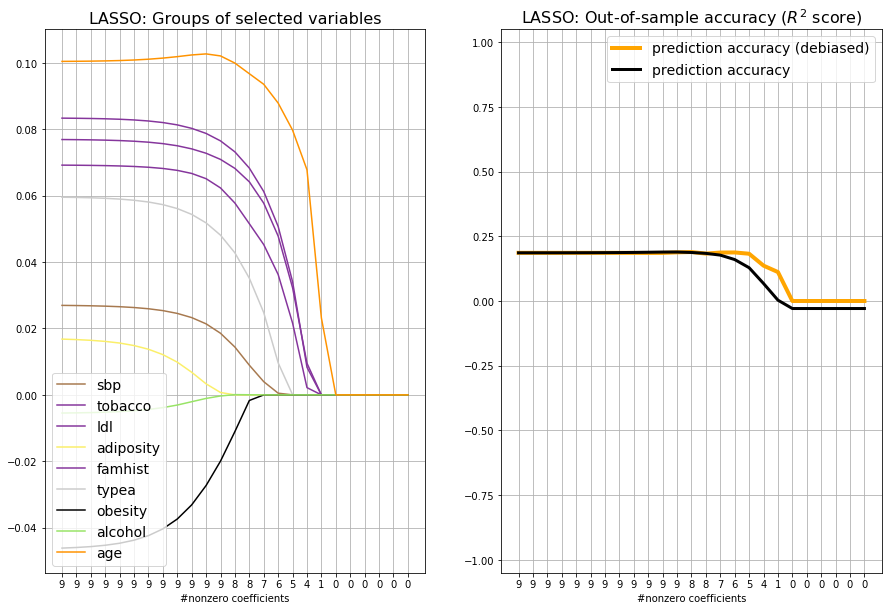

In [17]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2)  ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)


In [71]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  age                            with p-value 1.07418e-16
Add  famhist                        with p-value 1.10497e-05
Add  tobacco                        with p-value 0.000318949
Add  ldl                            with p-value 0.00133352
Add  typea                          with p-value 0.00585821
Add  obesity                        with p-value 0.115856
Add  sbp                            with p-value 0.199105
Add  adiposity                      with p-value 0.640422
Add  alcohol                        with p-value 0.775502
Forward-stepwise selection: age -> famhist -> tobacco -> ldl -> typea -> obesity -> sbp -> adiposity -> alcohol


### conclusion: largely in agreement
### the 5 significant variables are also the 5 most predictive variables -> sbp and obesity are 6. and 7. most predictive variables but they are not among the significant ones (p > 0.2 and p > 0.3)

In [28]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     9.182
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           8.04e-13
Time:                        15:54:49   Log-Likelihood:                -371.89
No. Observations:                 462   AIC:                             761.8
Df Residuals:                     453   BIC:                             799.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sbp            0.0274      0.028      0.973      0.3